In [ ]:
!pip install "numpy<2,>=1.13" "pandas~=1.1" "matplotlib<4,>=2.1" "lxml>=3.7" "nltk>=3.2" "beautifulsoup4>=4.6" "pypdf2>=1.26" "networkx>=2.8" "scipy<2,>=0.18" "scikit-learn>=0.19" "xlrd<2,>=1.0" "mpl-axes-aligner<2,>=1.1"

In [1]:
import matplotlib.pyplot as plt

(chp-getting-data)=
# Parsing and Manipulating Structured Data

(sec-getting-data-intro)=
## Introduction

In this chapter, we describe how to identify and visualize the "<span class="index">social
network</span>" of characters in a well-known play, *Hamlet*, using Python (see {numref}`fig:hamlet-network`). Our focus in this introductory chapter is not on the analysis of the properties of the network but rather on the necessary processing and parsing of machine-readable versions of texts. It is these texts, after all, which record the evidence from which a character network is constructed. If our goal is to identify and visualize a character network in a manner which can be reproduced by anyone, then this processing of texts is essential. We also review, in the context of a discussion of parsing various data formats, useful features of the Python language, such as tuple unpacking.
```{margin}
For the idea of visualizing the character network of *Hamlet* we are indebted to {cite:t}`moretti:2011`. Note, however, that Moretti's *Hamlet* network is not reproducible and depends on ad hoc determinations of whether or not characters interacted.
```

```{figure} img/hamlet-minimum-10-interactions.png
---
name: fig:hamlet-network
---
Network of *Hamlet* characters. Characters must interact at least ten times to be included.
```

To lend some thematic unity to the chapter, we draw all our examples from Shakespeariana,
making use of the tremendously rich and high-quality data provided by the <span class="index">Folger Digital Texts repository</span>, an important digital resource dedicated to the preservation and sharing of <span class="index">William Shakespeare</span>'s plays, sonnets, and poems. We begin with processing the simplest form of data, plain text, to explain the important concept of "character encoding" (section {ref}`sec-getting-data-txt`). From there, we move on to various popular forms of more complex, structural data markup. The extensible markup language (XML) is a topic that cannot be avoided here (section {ref}`sec-getting-data-xml`), because it is the dominant standard in the scholarly community, used, for example, by the influential Text Encoding Initiative (TEI) (section {ref}`sec-getting-data-tei`). Additionally, we survey Python's support for other types of structured data such as CSV (section {ref}`sec-getting-data-csv`), HTML (Section {ref}`sec-getting-data-html`), PDF (section {ref}`sec-getting-data-pdf`), and JSON (section {ref}`sec-getting-data-json`). In the final section, where we eventually (aim to) replicate the *Hamlet* character network, we hope to show how various file and data formats can be used with Python to exchange data in an efficient and platform-independent manner.

(sec-getting-data-txt)=
## Plain Text

Enormous amounts of data are now available in a machine-readable format. Much of this data is of interest to researchers in the humanities and interpretive social sciences. Major resources include [Project Gutenberg](https://www.gutenberg.org/), [Internet Archive](https://archive.org), and [Europeana](http://www.europeana.eu/portal/en). Such resources present data in a bewildering array of file formats, ranging from plain, unstructured text files to complex, intricate databases. Additionally, repositories differ in the way they organize the access to their collections: organizations such as Wikipedia provide [nightly dumps](https://dumps.wikimedia.org/backup-index.html) of their databases, downloadable by users to their own machines. Other institutions, such as [Europeana](http://www.europeana.eu/), provide access to their data through an <span class="index">Application Programming Interface</span> (API), which allows interested parties to search collections using specific queries. Accessing and dealing with pre-existing data, instead of creating it yourself, is an important skill for doing data analyses in the humanities and allied social sciences.

Digital data are stored in file formats reflecting conventions which enable us
to exchange data. One of the most common file formats is the "<span class="index">plain text</span>" format, where
data take the form of a series of human-readable characters. In Python, we can read such
plain text files into objects of type `str`. The chapter's data are stored as a compressed
tar archive, which can be decompressed using Python's standard library <span class="index">`tarfile`</span>:

In [2]:
import tarfile
tf = tarfile.open('data/folger.tar.gz', 'r')
tf.extractall('data')

Subsequently, we read a single plain text file into memory, using:

In [3]:
file_path = 'data/folger/txt/1H4.txt'
stream = open(file_path)
contents = stream.read()
stream.close()

print(contents[:300])

Henry IV, Part I
by William Shakespeare
Edited by Barbara A. Mowat and Paul Werstine
  with Michael Poston and Rebecca Niles
Folger Shakespeare Library
http://www.folgerdigitaltexts.org/?chapter=5&play=1H4
Created on Jul 31, 2015, from FDT version 0.9.2

Characters in the Play


Here, we open a file object (a so-called *stream*) to access the contents of a plain text version of one of Shakespeare's plays (*Henry IV, Part 1*), which we assign to `stream`. The location of this file is specified using a path as the single argument to the function <span class="index">`open()`</span>. Note that the path is a so-called "<span class="index">relative path</span>", which indicates where to find the desired file *relative* to Python's current position in the computer's file system. By convention, plain text files take the `.txt` extension to indicate that they contain plain text. This, however, is not obligatory. After opening a file object, the actual contents of the file is read as a string object by calling the method <span class="index">`read()`</span>. Printing the first 300 characters shows that we have indeed obtained a human-readable series of characters. Crucially, file connections should be closed as soon as they are no longer needed: calling <span class="index">`close()`</span> ensures that the data stream to the original file is cut off. A common and safer shortcut for opening, reading, and closing a file is the following:

In [4]:
with open(file_path) as stream:
    contents = stream.read()

print(contents[:300])

Henry IV, Part I
by William Shakespeare
Edited by Barbara A. Mowat and Paul Werstine
  with Michael Poston and Rebecca Niles
Folger Shakespeare Library
http://www.folgerdigitaltexts.org/?chapter=5&play=1H4
Created on Jul 31, 2015, from FDT version 0.9.2

Characters in the Play


The use of the <span class="index">`with`</span> statement in this code block ensures that `stream` will be automatically closed after the indented block has been executed. The rationale of such a `with` block is that it will execute all code under its scope; however, once done, it will close the file, *no matter what has happened*, i.e. even if an error might have been raised when reading the file. At a more abstract level, this use of `with` is an example of a so-called "<span class="index">context manager</span>" in Python that allows us to allocate and release resources exactly when and how we want to. The code example above is therefore both a very safe and the preferred method to open and read files: without it, running into a reading error will abort the execution of our code before the file has been closed, and no strict guarantees can be given as to whether the file object will be closed. Without further specification, `stream.read` loads the contents of a file object in its entirety, or, in other words, it reads all characters until it hits the <span class="index">end of file marker</span> (`EOF`).

It is important to realize that even the seemingly simple plain text format requires a good deal of conventions: it is a well-known fact that internally computers can only store binary information, i.e., arrays of zeros and ones. To store characters, then, we need some sort of "map" specifying how characters in plain text files are to be encoded using numbers. Such a map is called a "<span class="index">character encoding standard</span>". The oldest character encoding standard is the <span class="index">ASCII</span> standard (short for "American Standard Code for Information Interchange"). This standard has been dominant in the world of computing and specifies an influential mapping for a restrictive set of 128 basic characters drawn from the English-language alphabet, including some numbers, whitespace characters, and punctuation. (128 ($2^7$) distinct characters is the maximum number of symbols which can be encoded using seven bits per character.) ASCII has proven very important in the early days of computing, but in recent decades it has been gradually replaced by more inclusive encoding standards that also cover the characters used in other, non-Western languages.

Nowadays, the world of computing increasingly relies on the so-called <span class="index">Unicode</span> standard, which covers over 128,000 characters. The Unicode standard is implemented in a variety of actual encoding standards, such as <span class="index">UTF-8</span> and UTF-16. Fortunately for everyone---dealing with different encodings is very frustrating---UTF-8 has emerged as the standard for text encoding. As UTF-8 is a cleverly constructed superset of ASCII, all valid ASCII text files are valid UTF-8 files. Python nowadays assumes that any files opened for reading or writing in text mode use the default encoding on a computer's system; on macOS and Linux distributions, this is typically UTF-8, but this is not necessarily the case on Windows. In the latter case, you might want to supply an extra `encoding` argument to `open()` and make sure that you load a file using the proper encoding (e.g., `open(..., encoding='utf8')`). Additionally, files which do not use UTF-8 encoding can also be opened through specifying another `encoding` parameter. This is demonstrated in the following code block, in which we read the opening line---[KOI8-R](https://en.wikipedia.org/wiki/KOI8-R) encoded---of *Anna Karenina*:

In [5]:
with open('data/anna-karenina.txt', encoding='koi8-r') as stream:
    # Use stream.readline() to retrieve the next line from a file,
    # in this case the 1st one:
    line = stream.readline()

print(line)

Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.



Having discussed the very basics of plain text files and file encodings, we now move on to other, more structured forms of digital data.

(sec-getting-data-csv)=
## CSV

The plain text format is a human-readable, non-binary format. However, this does not necessarily imply that the content of such files is always just "raw data", i.e., unstructured text. In fact, there exist many simple data formats used to help structure the data contained in plain text files. The CSV-format we briefly touched upon in chapter {ref}`chp-introduction-cook-books`, for instance, is a very common choice to store data in files that often take the `.csv` extension. <span class="index">CSV</span> stands for "Comma-Separated Values". It is used to store tabular information in a spreadsheet-like manner. In its simplest form, each line in a CSV file represents an individual data entry, where attributes of that entry are listed in a series of fields separated using a delimiter (e.g., a comma):

In [6]:
csv_file = 'data/folger_shakespeare_collection.csv'
with open(csv_file) as stream:
    # call stream.readlines() to read all lines in the CSV file as a list.
    lines = stream.readlines()

print(lines[:3])

['fname,author,title,editor,publisher,pubplace,date\n', '1H4,William Shakespeare,"Henry IV, Part I",Barbara A. Mowat,Washington Square Press,New York,1994\n', '1H6,William Shakespeare,"Henry VI, Part 1",Barbara A. Mowat,Washington Square Press,New York,2008\n']


This example file contains bibliographic information about the Folger Shakespeare collection, in which each line represents a particular work. Each of these lines records a series of fields, holding the work's filename, author, title, editor, publisher, publication place, and date of publication. As one can see, the first line in this file contains a so-called "<span class="index">header</span>", which lists the names of the respective fields in each line. All fields in this file, header and records alike, are separated by a delimiter, in this case a comma. The comma delimiter is just a convention, and in principle any character can be used as a delimiter. The tab-separated format (extension `.tsv`), for instance, is another widely used file format in this respect, where the delimiter between adjacent fields on a line is the tab character (`\t`). Loading and parsing data from CSV or <span class="index">TSV</span> files would typically entail parsing the contents of the file into a list of lists:

In [7]:
entries = []
for line in open(csv_file):
    entries.append(line.strip().split(','))

for entry in entries[:3]:
    print(entry)

['fname', 'author', 'title', 'editor', 'publisher', 'pubplace', 'date']
['1H4', 'William Shakespeare', '"Henry IV', ' Part I"', 'Barbara A. Mowat', 'Washington Square Press', 'New York', '1994']
['1H6', 'William Shakespeare', '"Henry VI', ' Part 1"', 'Barbara A. Mowat', 'Washington Square Press', 'New York', '2008']


In this code block, we iterate over all lines in the CSV file. After removing any trailing whitespace characters (with <span class="index">`strip()`</span>), each line is transformed into a list of strings by calling `split(',')`, and subsequently added to the `entries` list. Note that such an ad hoc approach to parsing structured files, while attractively simple, is both naive and dangerous: for instance, we do not protect ourselves against empty or corrupt lines lacking entries. String variables stored in the file, such as a text's title, might also contain commas, causing parsing errors. Additionally, the header is not automatically detected nor properly handled. Therefore, it is recommended to employ packages specifically suited to the task of reading and parsing CSV files, which offer well-tested, flexible, and more robust parsing procedures. Python's standard library, for example, ships with the <span class="index">`csv`</span> module, which can help us parse such files in a much safer way. Have a look at the following code block. Note that we explicitly set the `delimiter` parameter to a comma (`','`) for demonstration purposes, although this in fact is already the parameter's default value in the `reader` function's signature.

In [8]:
import csv

entries = []
with open(csv_file) as stream:
    reader = csv.reader(stream, delimiter=',')
    for fname, author, title, editor, publisher, pubplace, date in reader:
        entries.append((fname, title))

for entry in entries[:5]:
    print(entry)

('fname', 'title')
('1H4', 'Henry IV, Part I')
('1H6', 'Henry VI, Part 1')
('2H4', 'Henry IV, Part 2')
('2H6', 'Henry VI, Part 2')


The code is very similar to our ad hoc approach, the crucial difference being that we leave the error-prone parsing of commas to the <span class="index">`csv.reader`</span>. Note that each line returned by the `reader` immediately gets "unpacked"" into a long list of seven variables, corresponding to the fields in the file's header. However, most of these variables are not actually used in the subsequent code. To shorten such lines and improve their readability, one could also rewrite the unpacking statement as follows:

In [9]:
entries = []
with open(csv_file) as stream:
    reader = csv.reader(stream, delimiter=',')
    for fname, _, title, *_ in reader:
        entries.append((fname, title))

for entry in entries[:5]:
    print(entry)

('fname', 'title')
('1H4', 'Henry IV, Part I')
('1H6', 'Henry VI, Part 1')
('2H4', 'Henry IV, Part 2')
('2H6', 'Henry VI, Part 2')


The `for`-statement in this code block adds a bit of syntactic sugar to conveniently extract the variables of interest (and can be useful to process other sorts of sequences too). First, it combines regular variable names with underscores to unpack a list of variables. These underscores allow us to ignore the variables we do not need. Below, we exemplify this convention by showing how to indicate interest only in the first and third element of a collection:

In [10]:
a, _, c, _, _ = range(5)
print(a, c)

0 2


Next, what does this `*_` mean? The use of these asterisks is exemplified by the following lines of code:

In [11]:
a, *l = range(5)
print(a, l)

0 [1, 2, 3, 4]


```{margin}
Readers familiar with programming languages like Lisp or Scheme will feel right at home here, as these "first, rest" pairs are reminiscent of Lisp's `car` and `cdr` operations.
```
Using this method of "<span class="index">tuple unpacking</span>", we unpack an iterable through splitting it into a "first, rest" tuple, which is roughly equivalent to:

In [12]:
seq = range(5)
a, l = seq[0], seq[1:]
print(a, l)

0 range(1, 5)


To further demonstrate the usefulness of such "starred" variables, consider the following example in which an iterable is segmented in a "first, middle, last" triplet:

In [13]:
a, *l, b = range(5)
print(a, l, b)

0 [1, 2, 3] 4


It will be clear that this syntax offers interesting functionality to quickly unpack iterables, such as the lines in a CSV file.

In addition to the CSV reader employed above (i.e., `csv.reader`), the `csv` module provides another reader object, <span class="index">`csv.DictReader`</span>, which transforms each row of a CSV file into a dictionary. In these dictionaries, keys represent the column names of the CSV file, and values point to the corresponding cells:

In [14]:
entries = []

with open(csv_file) as stream:
    reader = csv.DictReader(stream, delimiter=',')
    for row in reader:
        entries.append(row)

for entry in entries[:5]:
    print(entry['fname'], entry['title'])

1H4 Henry IV, Part I
1H6 Henry VI, Part 1
2H4 Henry IV, Part 2
2H6 Henry VI, Part 2
3H6 Henry VI, Part 3


The CSV format is often quite useful for simple data collections (we will give another example in chapter \ref{chp:working-with-data}), but for more complex data, scholars in the humanities and allied social sciences commonly resort to more expressive formats. Later on in this chapter, we will discuss XML, a widely used digital text format for exchanging data in a more structured fashion than plain text or CSV-like formats would allow. Before we get to that, however, we will first discuss two other common file formats, PDF and JSON, and demonstrate how to extract data from those.

(sec-getting-data-pdf)=
## PDF

The "Portable Document Format" (<span class="index">PDF</span>) is a file format commonly used to exchange digital documents in a way that preserves the formatting of text or inline images. Being a free yet proprietary format of Adobe since the early nineties, it was released as an open standard in 2008 and published by the International Organization for Standardization (ISO) under ISO 32000-1:2008. PDF documents encapsulate a complete description of their layout, fonts, graphics, and so on and so forth, with which they can be displayed on screen consistently and reliably, independent of software, hardware, or operating system. Being a fixed-layout document exchange format, the Portable Document Format has been and still is one of the most popular document sharing formats. It should be emphasized that PDF is predominantly a display format. As a source for (scientific) data storage and exchange, PDFs are hardly appropriate, and other file formats are to be preferred. Nevertheless, exactly because of the ubiquity of PDF, researchers often need to extract information from PDF files (such as OCR'ed books), which, as it turns out, can be a hassle. In this section we will therefore demonstrate how one could parse and extract text from PDF files using Python.

```{margin}
Note that the PyPDF2 library is already installed when the installation instructions of this book have been followed (see chapter {ref}`chp-introduction-cook-books`).
 ```
Unlike the CSV format, Python's standard library does not provide a module for parsing PDF files. Fortunately, a plethora of third-party packages fills this gap, such as [pyPDF2](https://pythonhosted.org/PyPDF2/), [pdfrw](https://github.com/pmaupin/pdfrw), and [pdfminer](http://www.unixuser.org/~euske/python/pdfminer/index.html). Here, we will use <span class="index">pyPDF2</span>, which is a pure-Python library for parsing, splitting, or merging PDF files. The library is available from the <span class="index">Python Package Index</span> ([PyPI](https://pypi.python.org/pypi)), and can be installed by running `pip install pypdf2` on the command-line. After installing, we import the package as follows:

In [15]:
import PyPDF2 as PDF

Reading and parsing PDF files can be accomplished with the library's <span class="index">`PdfReader`</span> object, as illustrated by the following lines of code:

In [16]:
file_path = 'data/folger/pdf/1H4.pdf'
pdf = PDF.PdfReader(file_path)

A `PdfReader` instance provides various methods to access information about a PDF file. For example, to retrieve the number of pages of a PDF file, we calculate the length of `pdf.pages`.

In [17]:
n_pages = len(pdf.pages)
print(f'PDF has {n_pages} pages.')

PDF has 113 pages.


Similarly, calling `PdfReader.pages[i]` retrieves a single page from a PDF file, which can then be used for further processing. In the code block below, we first retrieve the PDF's first page and, subsequently, call `extract_text()` upon the returned `PageObject` to extract the actual textual content of that page:

In [18]:
page = pdf.pages[1]
content = page.extract_text()
print(content[:150])

FrontMatterFrom the Director of the Folger ShakespeareLibraryTextual IntroductionSynopsisCharacters in the PlayACT 1Scene 1Scene 2Scene 3ACT 2Scene 1S


Note that the data parsing is far from perfect; line endings in particular are often particularly hard to extract correctly. Moreover, it can be challenging to correctly extract the data from consecutive text regions in a PDF, because being a display format, PDFs do not necessarily keep track of the original *logical* reading order of these text blocks, but merely store the blocks' "coordinates" on the page. For instance, when extracting text from a PDF page containing a header, three text columns, and a footer, we have no guarantees that the extracted data aligns with the order as presented on the page, while this would intuitively seem the most logical order in which a human would read these blocks. While there exist excellent parsers that aim to alleviate such interpretation artifacts, this is an important limitation of PDF to keep in mind: PDF is great for human reading, but not so much for machine reading or long-term <span class="index">data storage</span>.

To conclude this brief section on reading and parsing PDF files in Python, we demonstrate how to implement a simple, yet useful utility function to convert (parts of) PDF files into plain text. The function <span class="index">`pdf2txt()`</span> below implements a procedure to extract textual content from PDF files. It takes three arguments: (i) the file path to the PDF file (`fname`), (ii) the page numbers (`page_numbers`) for which to extract text (if `None`, all pages will be extracted), and (iii) whether to concatenate all pages into a single string or return a list of strings each representing a single page of text (`concatenate`).

The procedure is relatively straightforward, but some additional explanation to refresh your Python knowledge won't hurt. The lines following the function definition provide some documentation. Most functions in this book have been carefully documented, and we advise the reader to do the same. The body of the function consists of seven lines. First, we create an instance of the `PdfReader` object. We then check whether an argument was given to the parameter `page_numbers`. If no argument is given, we assume the user wants to transform all pages to strings. Otherwise, we only transform the pages corresponding to the given page numbers. If `page_numbers` is a single page (i.e., a single integer), we transform it into a list before proceeding. In the second-to-last line, we do the actual text extraction by calling `extractText()`. Note that the extraction of the pages happens inside a so-called "list comprehension", which is Python's syntactic construct for creating lists based on existing lists, and is related to the mathematical set-builder notation. Finally, we merge all texts into a single string using `'\n'.join(texts)` if `concatenate` is set to `True`. If `False` (the default), we simply return the list of texts.

In [19]:
def pdf2txt(fname, page_numbers=None, concatenate=False):
    """Convert text from a PDF file into a string or list of strings.

    Arguments:
        fname: a string pointing to the filename of the PDF file
        page_numbers: an integer or sequence of integers pointing to the
            pages to extract. If None (default), all pages are extracted.
        concatenate: a boolean indicating whether to concatenate the
            extracted pages into a single string. When False, a list of
            strings is returned.

    Returns:
        A string or list of strings representing the text extracted
        from the supplied PDF file.

    """
    pdf = PDF.PdfReader(fname)
    if page_numbers is None:
        page_numbers = range(len(pdf.pages))
    elif isinstance(page_numbers, int):
        page_numbers = [page_numbers]
    texts = [pdf.pages[n].extract_text() for n in page_numbers]
    return '\n'.join(texts) if concatenate else texts

The function is invoked as follows:

In [20]:
text = pdf2txt(file_path, concatenate=True)
sample = pdf2txt(file_path, page_numbers=[1, 4, 9])

(sec-getting-data-json)=
## JSON

<span class="index">JSON</span>, JavaScript Object Notation, is a lightweight data
format for storing and exchanging data, and is the dominant data-interchange format on the
web. JSON's popularity is due in part to its concise syntax, which draws on conventions
found in <span class="index">JavaScript</span> and other popular programming languages.
JSON stores information using four basic data types---"string" (in double quotes),
"number" (similar to Python's `float`---JSON has no integer type and is therefore unable to represent very large integer values.), "boolean" (`true` or `false`) and "null" (similar to Python's `None`)---and two data structures for collections of data---`object`, which is a collection of name/value pairs similar to Python's `dict`, and `array`, which is an ordered list of values, much like Python's `list`.

Let us first consider <span class="index">JSON</span> objects. Objects are enclosed with curly brackets (`{}`), and consist of name/value pairs separated by commas. JSON's name/value pairs closely resemble Python's dictionary syntax, as they take the form `name: value`. As shown in the following JSON fragment, names are represented as strings in double quotes:

```json
{
  "line_id": 14,
  "play_name": "Henry IV",
  "speech_number": 1,
  "line_number": "1.1.11",
  "speaker": "KING HENRY IV",
  "text_entry": "All of one nature, of one substance bred,"
}
```

Just as Python's dictionaries differ from lists, <span class="index">JSON</span> objects are different from arrays. JSON arrays use the same syntax as Python: square brackets with elements separated by commas. Here is an example:

```json
[
  {
    "line_id": 12664,
    "play_name": "Alls well that ends well",
    "speech_number": 1,
    "line_number": "1.1.1",
    "speaker": "COUNTESS",
    "text_entry": "In delivering my son from me, I bury a second husband."
  },
  {
    "line_id": 12665,
    "play_name": "Alls well that ends well",
    "speech_number": 2,
    "line_number": "1.1.2",
    "speaker": "BERTRAM",
    "text_entry": "And I in going, madam, weep o'er my father's death"
  }
]
```

It is important to note that values can in turn again be objects or arrays, thus enabling the construction of nested structures. As can be seen in the example above, developers can freely mix and nest arrays and objects containing name-value pairs in JSON.

Python's [<span class="index">`json`</span>](https://docs.python.org/3.7/library/json.html) module provides a number of functions for convenient encoding and decoding of JSON objects. Encoding Python objects or object hierarchies as JSON strings can be accomplished with <span class="index">`json.dumps()`</span>---`dumps` stands for "dump s(tring)":

In [21]:
import json

line = {
    'line_id': 12664,
    'play_name': 'Alls well that ends well',
    'speech_number': 1,
    'line_number': '1.1.1',
    'speaker': 'COUNTESS',
    'text_entry': 'In delivering my son from me, I bury a second husband.'
}

print(json.dumps(line))

{"line_id": 12664, "play_name": "Alls well that ends well", "speech_number": 1, "line_number": "1.1.1", "speaker": "COUNTESS", "text_entry": "In delivering my son from me, I bury a second husband."}


Similarly, to serialize Python objects to a file, we employ the function <span class="index">`json.dump()`</span>:

In [22]:
with open('shakespeare.json', 'w') as f:
    json.dump(line, f)

The function <span class="index">`json.load()`</span> is for decoding (or <span class="index">deserializing</span>) JSON files into a Python object, and <span class="index">`json.loads()`</span> decodes JSON formatted strings into Python objects. The following code block gives an illustration, in which we load a JSON snippet containing bibliographic records of 173 editions of Shakespeare's *Macbeth* as provided by [OCLC WorldCat](http://www.worldcat.org/). We print a small slice of that snippet below:

In [23]:
with open('data/macbeth.json') as f:
    data = json.load(f)

print(data[3:5])

[{'url': ['http://www.worldcat.org/oclc/71720750?referer=xid'], 'publisher': '1st World Library', 'form': ['BA'], 'lang': 'eng', 'city': 'Fairfield, IA', 'author': 'William Shakespeare.', 'year': '2005', 'isbn': ['1421813572'], 'title': 'The tragedy of Macbeth', 'oclcnum': ['71720750']}, {'url': ['http://www.worldcat.org/oclc/318064400?referer=xid'], 'publisher': 'Echo Library', 'form': ['BA'], 'lang': 'eng', 'city': 'Teddington, Middlesex', 'author': 'by William Shakespeare.', 'year': '2006', 'isbn': ['1406820997'], 'title': 'The tragedy of Macbeth', 'oclcnum': ['318064400']}]


After deserializing a JSON document with `json.load()` (i.e., converting it into a Python object), it can be accessed as normal Python `list` or `dict` objects. For example, to construct a frequency distribution of the languages in which these 173 editions are written, we can write the following:

In [24]:
import collections

languages = collections.Counter()
for entry in data:
    languages[entry['lang']] += 1

print(languages.most_common())

[('eng', 164), ('ger', 3), ('spa', 3), ('fre', 2), ('cat', 1)]


For those unfamiliar with the [<span class="index">`collections`</span>](https://docs.python.org/3/library/collections.html) module and its <span class="index">`Counter`</span> object, this is how it works: A `Counter` object is a `dict` subclass for counting immutable objects. Elements are stored as dictionary keys (accessible through `Counter.keys()`) and their counts are stored as dictionary values (accessible through `Counter.values()`). Being a subclass of `dict`, `Counter` inherits all methods available for regular dictionaries (e.g., `dict.items()`, `dict.update()`). By default, a key's value is set to zero. This allows us to increment a key's count for each occurrence of that key (cf. lines 4 and 5). The method <span class="index">`Counter.most_common()`</span> is used to construct a list of the *n* most common elements. The method returns the keys and their counts in the form of `(key, value)` tuples.

(sec-getting-data-xml)=
## XML

In digital applications across the humanities, <span class="index">XML</span> or the [eXtensible Markup Language](https://www.w3.org/XML/) is the dominant format for modeling texts, especially in the field of Digital Scholarly Editing, where scholars are concerned with the electronic editions of texts {cite:p}`pierazzo:2015`. XML is a powerful and very common format for enriching (textual) data. XML is a so-called "<span class="index">markup language</span>": it specifies a syntax allowing for "semantic" data annotations, which provide means to add layers of meaningful, descriptive metadata on top of the original, raw data in a plain text file. XML, for instance, allows making explicit the function or meaning of the words in documents. Reading the text of a play as a plain text, to give but one example, does not provide any formal cues as to which scene or act a particular utterance belongs, or by which character the utterance was made. XML allows us to keep track of such information by making it explicit.

The syntax of <span class="index">XML</span> is best explained through an example, since it is very intuitive. Let us consider the following short, yet illustrative example using the well-known "Sonnet 18" by Shakespeare:

In [25]:
with open('data/sonnets/18.xml') as stream:
    xml = stream.read()

print(xml)

<?xml version="1.0"?>
<sonnet author="William Shakepeare" year="1609">
	<line n="1">Shall I compare thee to a summer's <rhyme>day</rhyme>?</line>
	<line n="2">Thou art more lovely and more <rhyme>temperate</rhyme>:</line>
	<line n="3">Rough winds do shake the darling buds of <rhyme>May</rhyme>,</line>
	<line n="4">And summer's lease hath all too short a <rhyme>date</rhyme>:</line>
	<line n="5">Sometime too hot the eye of heaven <rhyme>shines</rhyme>,</line>
	<line n="6">And often is his gold complexion <rhyme>dimm'd</rhyme>;</line>
	<line n="7">And every fair from fair sometime <rhyme>declines</rhyme>,</line>
	<line n="8">By chance, or nature's changing course, <rhyme>untrimm'd</rhyme>;</line>
    <volta/>
	<line n="9">But thy eternal summer shall not <rhyme>fade</rhyme></line>
	<line n="10">Nor lose possession of that fair thou <rhyme>ow'st</rhyme>;</line>
	<line n="11">Nor shall Death brag thou wander'st in his <rhyme>shade</rhyme>,</line>
	<line n="12">When in eternal lines to time 

The first line (`<?xml version="1.0"?>`) is a sort of "prolog" declaring the exact version of XML we are using---in our case, that is simply version 1.0. Including a prolog is optional according to the XML syntax but it is a good place to specify additional information about a file, such as its encoding (`<?xml version="1.0" encoding="utf-8"?>`). When provided, the prolog should always be on the first line of an XML document. It is only after the prolog that the actual content comes into play. As can be seen at a glance, <span class="index">XML</span> encodes pieces of text in a similar way as <span class="index">HTML</span> (see section {ref}`sec-getting-data-html`), using start tags (e.g., `<line>`, `<rhyme>`) and corresponding end tags (`</line>`, `</rhyme>`) which are enclosed by angle brackets. Each start tag must normally correspond to exactly one end tag, or you will run into parsing errors when processing the file. Nevertheless, XML does allow for "solo" elements, such the `<volta/>` tag after line 8 in this example, which specifies the classical "turning point" in sonnets. Such tags are "self-closing", so to speak, and they are also called "empty" tags. Importantly, <span class="index">XML tags</span> are not allowed to overlap. The following line would therefore not constitute valid XML:

```xml
<line n="11">
  Nor shall Death brag thou wander'st in his <rhyme>shade,
</line></rhyme>
```

The problem here is that the `<rhyme>` element should have been closed by the corresponding end tag (`</rhyme>`), before we can close the parent element using `</line>`. This limitation results from the fact that XML is a *hierarchical* markup language: it assumes that we can and should model a text document as a tree of branching nodes. In this tree, elements cannot have more than one direct parent element, because otherwise the hierarchy would be ambiguous. The one exception is the so-called root element, which is the highest node in a tree. Hence, it does not have a parent element itself, and thus cannot have siblings. All non-root elements can have as many siblings and children as needed. All the `<line>` elements in our sonnet, for example, are siblings, in the sense that they have a direct parent element in common, i.e., the `<sonnet>` tag. The fact that elements cannot overlap in XML is a constant source of frustration and people often come up with creative workarounds for the limitation imposed by this hierarchical format.

XML does not come with predefined tags; it only defines a syntax to define those tags. Users can therefore invent and use their own tag set and markup conventions, as long as the documents formally adhere to the XML standard syntax. We say that documents are "well-formed" when they conform completely to the XML standard, which is something that can be checked using validation applications (see, e.g., the [W3Schools validator](http://www.w3schools.com/xml/xml_validator.asp)). For even more descriptive precision, XML tags can take so-called "attributes", which consist of a name and a value. The `sonnet` element, for instance, has two attributes: the attribute names `author` and `year` are mapped to the values `"William Shakespeare"` and `"1609"` respectively. Names do not take surrounding double quotes but values do; they are linked by an equal sign (`=`). The name and element pairs inside a single tag are separated by a space character. Only start tags and standalone tags can take attributes (e.g., `<volta n="1"/>`); closing tags cannot. According to the <span class="index">XML</span> standard, the order in which attributes are listed is insignificant.

Researchers in the humanities nowadays put a lot of time and effort in creating digital data sets for their research, such as <span class="index">scholarly editions</span> with a rich markup encoded in XML. Nevertheless, once data have been annotated, it can be challenging to subsequently extract the textual contents, and to fully exploit the information painstakingly encoded. It is therefore crucial to be able to parse XML in an efficient manner. Luckily, Python provides the necessary functionality for this. In this section, we will make use of some of the functionality included in the <span class="index">`lxml`</span> library, which is commonly used for XML parsing in the Python ecosystem, although there exist a number of alternative packages. It should be noted that there exist languages such as <span class="index">XSLT</span> ([Extensible Stylesheet Language Transformations](https://www.w3.org/Style/XSL/)) which are particularly well equipped to manipulate XML documents. Depending on the sort of task you wish to achieve, these languages might make it easier than Python to achieve certain transformations and manipulations of XML documents. Languages such as XSLT, on the other hand, are less general programming languages and might miss support for more generic functionality.

(sec-getting-data-parsing-xml)=
### Parsing XML

We first import the lxml's central module `etree`:

In [26]:
import lxml.etree

After importing `etree`, we can start parsing the XML data that represents our sonnet:

In [27]:
tree = lxml.etree.parse('data/sonnets/18.xml')
print(tree)

We have now read and parsed our sonnet via the <span class="index">`lxml.etree.parse()`</span> function, which accepts the path to a file as a parameter. We have also assigned the XML tree structure returned by the `parse` function to the `tree` variable, thus enabling subsequent processing. If we print the variable `tree` as such, we do not get to see the raw text from our file, but rather an indication of `tree`'s object type, i.e., the <span class="index">`lxml.etree._ElementTree`</span> type. To have a closer look at the original <span class="index">XML</span> as printable text, we transform the tree into a string object using `lxml.etree.tostring(tree)` before printing it (note that the initial line from our file, containing the XML metadata, is not included anymore):

In [28]:
# decoding is needed to transform the bytes object into an actual string
print(lxml.etree.tostring(tree).decode())

<sonnet author="William Shakepeare" year="1609">
	<line n="1">Shall I compare thee to a summer's <rhyme>day</rhyme>?</line>
	<line n="2">Thou art more lovely and more <rhyme>temperate</rhyme>:</line>
	<line n="3">Rough winds do shake the darling buds of <rhyme>May</rhyme>,</line>
	<line n="4">And summer's lease hath all too short a <rhyme>date</rhyme>:</line>
	<line n="5">Sometime too hot the eye of heaven <rhyme>shines</rhyme>,</line>
	<line n="6">And often is his gold complexion <rhyme>dimm'd</rhyme>;</line>
	<line n="7">And every fair from fair sometime <rhyme>declines</rhyme>,</line>
	<line n="8">By chance, or nature's changing course, <rhyme>untrimm'd</rhyme>;</line>
    <volta/>
	<line n="9">But thy eternal summer shall not <rhyme>fade</rhyme></line>
	<line n="10">Nor lose possession of that fair thou <rhyme>ow'st</rhyme>;</line>
	<line n="11">Nor shall Death brag thou wander'st in his <rhyme>shade</rhyme>,</line>
	<line n="12">When in eternal lines to time thou <rhyme>grow'st</r

In what follows, we will demonstrate how to navigate the XML tree. Often we will be interested in specific elements in the tree only, such as the rhyme words inside the `<rhyme>` tags, instead of the entirety of the tree's complex structure. The high-level method `interfind()` allows us to easily loop over all the element in our tree and search it for specific elements. To query the tree for all rhyme elements, we pass the string `"//rhyme"` as an argument to this function: this string can be formatted using [<span class="index">XPath</span>](http://www.w3schools.com/xml/xml_xpath.asp) query syntax, a search language used to query XML files. We cannot fully cover that query syntax here, but in our present case, the double back slash simply indicates that we are interested in `<rhyme>` elements, no matter where in the tree they occur. Again, printing the rhyme elements themselves is not exactly insightful, since we only print rather prosaic information about the Python objects representing our rhyme words. We can use the `tag` attribute of such elements to print the tag's name and the `text` attribute to extract the text contained in the elements, i.e., the actual rhyme words:

In [29]:
for rhyme in tree.iterfind('.//rhyme'):
    print(f'element: {rhyme.tag} -> {rhyme.text}')

element: rhyme -> day
element: rhyme -> temperate
element: rhyme -> May
element: rhyme -> date
element: rhyme -> shines
element: rhyme -> dimm'd
element: rhyme -> declines
element: rhyme -> untrimm'd
element: rhyme -> fade
element: rhyme -> ow'st
element: rhyme -> shade
element: rhyme -> grow'st
element: rhyme -> see
element: rhyme -> thee


Until now, we have been iterating over the `<rhyme>` elements in their simple order of appearance: we haven't really been exploiting the hierarchy of the XML tree yet. Let us see now how to actually navigate and traverse the XML tree. First, we select the root node or top node, which forms the beginning of the entire tree:

In [30]:
root = tree.getroot()
print(root.tag)

sonnet


As explained above, the `<sonnet>` root element in our <span class="index">XML</span> file
has two additional attributes. The values of the attributes of an element can be accessed via the attribute `attrib`, which allows us to access the attribute information of an element in a dictionary-like fashion, thus via key-based indexing:

In [31]:
print(root.attrib['year'])

1609


Now that we have selected the root element, we can start drilling down the tree's structure. Let us first find out how many child nodes the root element has. The number of children of an element can be retrieved by employing the function <span class="index">`len()`</span>:

In [32]:
print(len(root))

15


The root element has fifteen children, that is: fourteen `<line>` elements and one `<volta>` element. Elements with children function like iterable collections, and thus their children can be iterated as follows:

In [33]:
children = [child.tag for child in root]

How could we now extract the actual text in our poem while iterating over the tree? Could we simply call the `text` property on each element?

In [34]:
print('\n'.join(child.text or '' for child in root))

Shall I compare thee to a summer's 
Thou art more lovely and more 
Rough winds do shake the darling buds of 
And summer's lease hath all too short a 
Sometime too hot the eye of heaven 
And often is his gold complexion 
And every fair from fair sometime 
By chance, or nature's changing course, 

But thy eternal summer shall not 
Nor lose possession of that fair thou 
Nor shall Death brag thou wander'st in his 
When in eternal lines to time thou 
So long as men can breathe or eyes can 
So long lives this, and this gives life to 


The answer is *no*, since the text included in the `<rhyme>` element would not be included: the `text` property will only yield the first piece of pure text contained under a specific element, and not the text contained in an element's child elements or subsequent pieces of text thereafter, such as the verse-final punctuation. Here the `itertext()` method comes in useful. This function constructs an iterator over the entire textual content of the subtree of the `<line>` element. For the very first verse line, this gives us the following textual "offspring":

In [35]:
print(''.join(root[0].itertext()))

Shall I compare thee to a summer's day?


To extract the actual text in our lines, then, we could use something like the following lines of code:

In [36]:
for node in root:
    if node.tag == 'line':
        print(f"line {node.attrib['n']: >2}: {''.join(node.itertext())}")

line  1: Shall I compare thee to a summer's day?
line  2: Thou art more lovely and more temperate:
line  3: Rough winds do shake the darling buds of May,
line  4: And summer's lease hath all too short a date:
line  5: Sometime too hot the eye of heaven shines,
line  6: And often is his gold complexion dimm'd;
line  7: And every fair from fair sometime declines,
line  8: By chance, or nature's changing course, untrimm'd;
line  9: But thy eternal summer shall not fade
line 10: Nor lose possession of that fair thou ow'st;
line 11: Nor shall Death brag thou wander'st in his shade,
line 12: When in eternal lines to time thou grow'st;
line 13: So long as men can breathe or eyes can see,
line 14: So long lives this, and this gives life to thee.


(sec-getting-data-creating-xml)=
### Creating XML

Having explained the basics of *parsing* XML, we now turn to creating XML, which is equally relevant when it comes to exchanging data. <span class="index">XML</span> is a great format for the long-term storage of data, and once a data set has been analyzed and enriched, XML is a powerful output format for exporting and sharing data. In the following code block, we read a plain text version of another sonnet by Shakespeare ("Sonnet 116"):

In [37]:
with open('data/sonnets/116.txt') as stream:
    text = stream.read()

print(text)

Let me not to the marriage of true minds
Admit impediments. Love is not love
Which alters when it alteration finds,
Or bends with the remover to remove:
O no; it is an ever-fixed mark, 
That looks on tempests, and is never shaken;
It is the star to every wandering bark,
Whose worth's unknown, although his height be taken.
Love's not Time's fool, though rosy lips and cheeks 
Within his bending sickle's compass come; 
Love alters not with his brief hours and weeks, 
But bears it out even to the edge of doom.
If this be error and upon me proved,
I never writ, nor no man ever loved.


In what follows, we will attempt to enrich this raw text with the same markup as "Sonnet 18". We start by creating a root element and add two attributes to it:

In [38]:
root = lxml.etree.Element('sonnet')
root.attrib['author'] = 'William Shakespeare'
root.attrib['year'] = '1609'

The root element is initiated through the <span class="index">`Element()`</span> function. After initializing the element, we can add attributes to it, just as if we would do when populating an ordinary Python dictionary. After transforming the root node into an instance of <span class="index">`lxml.etree._ElementTree`</span>, we print it to screen:

In [39]:
tree = lxml.etree.ElementTree(root)
stringified = lxml.etree.tostring(tree)
print(stringified)

b'<sonnet author="William Shakespeare" year="1609"/>'


Note the `b` which is printed in front of the actual string. This prefix indicates that we are dealing with a string of <span class="index">bytes</span>, instead of <span class="index">Unicode</span> characters:

In [40]:
print(type(stringified))

<class 'bytes'>


For some applications, it is necessary to decode such objects into a proper string:

In [41]:
print(stringified.decode('utf-8'))

<sonnet author="William Shakespeare" year="1609"/>


Adding children to the root element is accomplished through initiating new elements, and, subsequently, appending them to the root element:

In [42]:
for nb, line in enumerate(open('data/sonnets/116.txt')):
    node = lxml.etree.Element('line')
    node.attrib['n'] = str(nb + 1)
    node.text = line.strip()
    root.append(node)
    # voltas typically, but not always occur between the octave and sextet
    if nb == 8:
        node = lxml.etree.Element('volta')
        root.append(node)

We print the newly filled tree structure using the `pretty_print` argument of the function <span class="index">`lxml.etree.to_string()`</span> to obtain a human-readable, indented tree:

In [43]:
print(lxml.etree.tostring(tree, pretty_print=True).decode())

<sonnet author="William Shakespeare" year="1609">
  <line n="1">Let me not to the marriage of true minds</line>
  <line n="2">Admit impediments. Love is not love</line>
  <line n="3">Which alters when it alteration finds,</line>
  <line n="4">Or bends with the remover to remove:</line>
  <line n="5">O no; it is an ever-fixed mark,</line>
  <line n="6">That looks on tempests, and is never shaken;</line>
  <line n="7">It is the star to every wandering bark,</line>
  <line n="8">Whose worth's unknown, although his height be taken.</line>
  <line n="9">Love's not Time's fool, though rosy lips and cheeks</line>
  <volta/>
  <line n="10">Within his bending sickle's compass come;</line>
  <line n="11">Love alters not with his brief hours and weeks,</line>
  <line n="12">But bears it out even to the edge of doom.</line>
  <line n="13">If this be error and upon me proved,</line>
  <line n="14">I never writ, nor no man ever loved.</line>
</sonnet>



The observant reader may have noticed that one difficult challenge remains: the existing tree must be manipulated in such a way that the rhyme words get enclosed by the proper tag. This is not trivial, because, at the same time, we want to make sure that the verse-final punctuation is not included in that element because, strictly speaking, it is not part of the rhyme. The following longer piece code takes care of this. We have added detailed comments to each line. Take some time to read it through.

In [44]:
# Loop over all nodes in the tree
for node in root:
    # Leave the volta node alone. A continue statement instructs
    # Python to move on to the next item in the loop.
    if node.tag == 'volta':
        continue
    # We chop off and store verse-final punctuation:
    punctuation = ''
    if node.text[-1] in ',:;.':
        punctuation = node.text[-1]
        node.text = node.text[:-1]
    # Make a list of words using the split method
    words = node.text.split()
    # We split rhyme words and other words:
    other_words, rhyme = words[:-1], words[-1]
    # Replace the node's text with all text except the rhyme word
    node.text = ' '.join(other_words) + ' '
    # We create the rhyme element, with punctuation (if any) in its tail
    elt = lxml.etree.Element('rhyme')
    elt.text = rhyme
    elt.tail = punctuation
    # We add the rhyme to the line:
    node.append(elt)

tree = lxml.etree.ElementTree(root)
print(lxml.etree.tostring(tree, pretty_print=True).decode())

<sonnet author="William Shakespeare" year="1609">
  <line n="1">Let me not to the marriage of true <rhyme>minds</rhyme></line>
  <line n="2">Admit impediments. Love is not <rhyme>love</rhyme></line>
  <line n="3">Which alters when it alteration <rhyme>finds</rhyme>,</line>
  <line n="4">Or bends with the remover to <rhyme>remove</rhyme>:</line>
  <line n="5">O no; it is an ever-fixed <rhyme>mark</rhyme>,</line>
  <line n="6">That looks on tempests, and is never <rhyme>shaken</rhyme>;</line>
  <line n="7">It is the star to every wandering <rhyme>bark</rhyme>,</line>
  <line n="8">Whose worth's unknown, although his height be <rhyme>taken</rhyme>.</line>
  <line n="9">Love's not Time's fool, though rosy lips and <rhyme>cheeks</rhyme></line>
  <volta/>
  <line n="10">Within his bending sickle's compass <rhyme>come</rhyme>;</line>
  <line n="11">Love alters not with his brief hours and <rhyme>weeks</rhyme>,</line>
  <line n="12">But bears it out even to the edge of <rhyme>doom</rhyme>.</li

This code does not contain any new functionality, except for the manipulation of the
`tail` attribute for some elements. By assigning text to an element's `tail` attribute, we can specify text which should immediately follow an element, before any subsequent element will start. Having obtained the envisaged rich XML structure, we will now save the tree to an XML file. To add an XML declaration and to specify the correct file encoding, we supply a number of additional parameters to the <span class="index">`lxml.etree.tostring()`</span> function:

In [45]:
with open('data/sonnets/116.xml', 'w') as f:
    f.write(
        lxml.etree.tostring(
            root, xml_declaration=True, pretty_print=True, encoding='utf-8').decode())

The current encoding of both our sonnets is an excellent example of an <span class="index">XML</span> document in which elements can contain both sub elements, as well as "free" text. Such documents are in fact really common in the humanities (e.g. many text editions will be of this type) and are called *mixed-content* XML, meaning that nodes containing only plain text can be direct siblings to other elements. <span class="index">Mixed-content XML</span> can be relatively more challenging to parse than XML that does not allow such mixing of elements. In the following, longer example, we create an alternative version of the sonnet, where all text nodes have been enclosed with `w`-elements (for the purely alphabetic strings in words) and `c`-elements (for punctuation and spaces). This XML content can no longer be called "mixed", because the plain text is never a direct sibling to a non-textual element in the tree's hierarchy. While such a file is extremely verbose, and thus much harder to read for a human, it can in some cases be simpler to parse for a machine. As always, your approach will be dictated by the specifics of the problem you are working on.

In [46]:
root = lxml.etree.Element('sonnet')
# Add an author attribute to the root node
root.attrib['author'] = 'William Shakespeare'
# Add a year attribute to the root node
root.attrib['year'] = '1609'

for nb, line in enumerate(open('data/sonnets/116.txt')):
    line_node = lxml.etree.Element('line')
    # Add a line number attribute to each line node
    line_node.attrib['n'] = str(nb + 1)

    # Make different nodes for words and non-words
    word = ''
    for char in line.strip():
        if char.isalpha():
            word += char
        else:
            word_node = lxml.etree.Element('w')
            word_node.text = word
            line_node.append(word_node)
            word = ''

            char_node = lxml.etree.Element('c')
            char_node.text = char
            line_node.append(char_node)

    # don't forget last word:
    if word:
        word_node = lxml.etree.Element('w')
        word_node.text = word
        line_node.append(word_node)

    rhyme_node = lxml.etree.Element('rhyme')
    # We use xpath to find the final w-element in the line
    # and wrap it in a line element
    rhyme_node.append(line_node.xpath('//w')[-1])
    line_node.replace(line_node.xpath('//w')[-1], rhyme_node)

    root.append(line_node)

    # Add the volta node
    if nb == 8:
        node = lxml.etree.Element('volta')
        root.append(node)

tree = lxml.etree.ElementTree(root)
xml_string = lxml.etree.tostring(tree, pretty_print=True).decode()
# Print a snippet of the tree:
print(xml_string[:xml_string.find("</line>") + 8] + '  ...')

<sonnet author="William Shakespeare" year="1609">
  <line n="1">
    <w>Let</w>
    <c> </c>
    <w>me</w>
    <c> </c>
    <w>not</w>
    <c> </c>
    <w>to</w>
    <c> </c>
    <w>the</w>
    <c> </c>
    <w>marriage</w>
    <c> </c>
    <w>of</w>
    <c> </c>
    <rhyme>
      <w>minds</w>
    </rhyme>
    <c> </c>
  </line>
  ...


(sec-getting-data-tei)=
### TEI

A name frequently mentioned in connection to XML and computational work in the humanities
is the <span class="index">Text Encoding Initiative</span>
([TEI](http://www.tei-c.org/index.xml)). This is an international scholarly consortium,
which maintains a set of guidelines that specify a "best practice" as to how one can best
mark up texts in humanities scholarship. The <span class="index">TEI</span> is currently used in a variety of digital projects across the humanities, but also in the so-called GLAM sector (Galleries, Libraries, Archives, and Museums). The TEI provides a large online collection of tag descriptions, which can be used to annotate and enrich texts. For example, if someone is editing a handwritten codex in which a scribe has crossed out a word and added a correction on top of the line, the TEI guidelines suggest the use of a `<del>` element to transcribe the deleted word and the `<add>` element to mark up the superscript addition. The TEI provides over 500 tags in their current version of the Guidelines (this version is called "P5").

The <span class="index">TEI</span> offers *guidelines* and it is not a standard, meaning that it leaves users and projects free to adapt these guidelines to their own specific needs. Although there are many projects that use TEI, there are not that many projects that are fully compliant with the P5 specification, because small changes to the TEI guidelines are often made to make them usable for specific projects. This can be a source of frustration for developers, because even though a document claims to "use the TEI" or "to be TEI-compliant", one never really knows what that exactly means.

For digital text analysis, there are a number of great datasets encoded using "TEI-inspired" XML. The <span class="index">Folger Digital Texts</span> is such a dataset. All XML encoded texts are located under the `data/folger/xml` directory. This resource provides a very rich and detailed markup: apart from extensive metadata about the play or detailed descriptions of the actors involved, the actual lines have been encoded in such a manner that we perfectly know which character uttered a particular line, or to which scene or act a line belongs. This allows us to perform much richer textual analyses than would be the case with raw text versions of the plays.

As previously mentioned, XML does not specify any predefined tags, and thus allows developers to flexibly define their own set of element names. The potential danger of this practice, however, is that name conflicts arise when XML documents from different XML applications are mixed. To avoid such name conflicts, XML allows the specification of so-called <span class="index">XML namespaces</span>. For example, the root elements of the Folger XML files specify the following namespace:

```xml
<TEI xmlns="http://www.tei-c.org/ns/1.0">
```

By specifying a namespace at the root level, the tag names of all children are internally prefixed with the supplied namespace. This means that a tag name like `author` is converted to `{http://www.tei-c.org/ns/1.0}author`, which, crucially, needs to be accounted for when navigating the document. For example, while titles are enclosed with the `title` tag name, extracting a document's title requires prefixing `title` with the specified namespace:

In [47]:
tree = lxml.etree.parse('data/folger/xml/Oth.xml')
print(tree.getroot().find('.//{http://www.tei-c.org/ns/1.0}title').text)

Othello


Note that, because of the introduction of a namespace, we can no longer find the original element *without* this namespace prefix:

In [48]:
print(tree.getroot().find('title'))

None


To reduce search query clutter, <span class="index">lxml</span> allows specifying namespaces as an argument to its search functions, such as `find()` and `xpath()`. By providing a namespace map (of type `dict`), consisting of self-defined prefixes (keys) and corresponding namespaces (values), search queries can be simplified to `prefix:tag`, where "prefix" refers to a namespace's key and "tag" to a particular tag name. The following example illustrates the use of these namespace maps:

In [49]:
NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}
print(tree.getroot().find('.//tei:title', namespaces=NSMAP).text)

Othello


(sec-getting-data-html)=
## HTML

In this section we will briefly discuss how to parse and process <span class="index">HTML</span>, which is another common source of data for digital text analysis. <span class="index">HTML</span>, which is an abbreviation for "HyperText Markup Language", is the standard markup language for the web. HTML is often considered a "cousin" of XML, because both markup languages have developed from a common ancestor (SGML), which has largely grown out of fashion nowadays. Historically, an attractive and innovative feature of HTML was that it could support hypertext: documents and files that are linked by so-called directly referenced links, now more commonly known as hyperlinks. HTML documents may contain valuable data for digital text analysis, yet due to a lack of very strict formatting standards and poorly designed websites, these data are often hard to reach.

To unlock these data, this section will introduce another third-party library called "[BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/)", which is one of the most popular Python packages for parsing, manipulating, navigating, searching, and, most importantly, pulling data out of HTML files. This chapter's introduction of <span class="index">BeautifulSoup</span> will necessarily be short and will not be able to cover all of its functionality. For a comprehensive introduction, we refer the reader to the excellent documentation available from the library's website. Additionally, we should stress that while BeautifulSoup is intuitive and easy to work with, data from the web are typically extremely noisy and therefore challenging to process.

The following code block displays a simplified fragment of HTML from Shakespeare's "<span class="index">Henry IV</span>":

```html
<html>
  <head>
    <title>Henry IV, Part I</title>
  </head>
  <body>
    <div>
      <p class="speaker">KING</p>
      <p id="line-1.1.1">
        <a id="ftln-0001">FTLN 0001</a>
        So shaken as we are, so wan with care,
      </p>
      <p id="line-1.1.2">
        <a id="ftln-0002">FTLN 0002</a>
        Find we a time for frighted peace to pant
      </p>
      <p id="line-1.1.3">
        <a id="ftln-0003">FTLN 0003</a>
        And breathe short-winded accents of new broils
      </p>
      <p id="line-1.1.4">
        <a id="ftln-0004">FTLN 0004</a>
        To be commenced in strands afar remote.
      </p>
    </div>
  </body>
</html>
```

Essentially, and just like XML, HTML consists of tags and content. Tags are element names surrounded by angle brackets (e.g., `<html>`), and normally come in pairs, i.e., `<html>` and `</html>` where the first tag functions as the start tag and the second as the end tag. Note that the end tag adds a forward slash before the tag name. The `<html>` element forms the root of the HTML document and surrounds all children elements. `<head>` elements provide meta information about a particular document. In this fragment, the `<head>` provides information about the document's title, which is enclosed with `<title>Henry IV, Part I</title>`. The body of an HTML document provides all content visible on a rendered webpage. Here, the body consists of a single `div` element, which is commonly used to indicate a division or section in HTML files. The `div` element has five children, all `<p>` elements defining paragraphs. The `<p>` elements provide additional meta information through their use of attributes: the first paragraph is of the class "speaker"; the remaining paragraphs have explicit IDs assigned to them (e.g., `id="line-1.1.4"`). The `<a>` tags inside the paragraph elements define hyperlinks, which can be used to navigate from one page to another or to different positions on a page.

To parse this fragment into a Python object, we employ BeautifulSoup's main workhorse class, `BeautifulSoup`, with which HTML documents can be represented as nested data structures in Python:

In [50]:
import bs4 as bs

html_doc = """
<html>
  <head>
    <title>Henry IV, Part I</title>
  </head>
  <body>
    <div>
      <p class="speaker">KING</p>
      <p id="line-1.1.1">
        <a id="ftln-0001">FTLN 0001</a>
        So shaken as we are, so wan with care,
      </p>
      <p id="line-1.1.2">
        <a id="ftln-0002">FTLN 0002</a>
        Find we a time for frighted peace to pant
      </p>
      <p id="line-1.1.3">
        <a id="ftln-0003">FTLN 0003</a>
        And breathe short-winded accents of new broils
      </p>
      <p id="line-1.1.4">
        <a id="ftln-0004">FTLN 0004</a>
        To be commenced in strands afar remote.
      </p>
    </div>
  </body>
</html>
"""

html = bs.BeautifulSoup(html_doc, 'html.parser')

After parsing the document, the `BeautifulSoup` object provides various ways to navigate or search the data structure. Some common navigation and searching operations are illustrated in the following code blocks:

In [51]:
# print the document's <title> (from head)
print(html.title)

<title>Henry IV, Part I</title>


In [52]:
# print the first <p> element and its content
print(html.p)

<p class="speaker">KING</p>


In [53]:
# print the text of a particular element, e.g. the <title>
print(html.title.text)

Henry IV, Part I


In [54]:
# print the parent tag (and its content) of the first <p> element
print(html.p.parent)

<div>
<p class="speaker">KING</p>
<p id="line-1.1.1">
<a id="ftln-0001">FTLN 0001</a>
        So shaken as we are, so wan with care,
      </p>
<p id="line-1.1.2">
<a id="ftln-0002">FTLN 0002</a>
        Find we a time for frighted peace to pant
      </p>
<p id="line-1.1.3">
<a id="ftln-0003">FTLN 0003</a>
        And breathe short-winded accents of new broils
      </p>
<p id="line-1.1.4">
<a id="ftln-0004">FTLN 0004</a>
        To be commenced in strands afar remote.
      </p>
</div>


In [55]:
# print the parent tag name of the first <p> element
print(html.p.parent.name)

div


In [56]:
# find all occurrences of the <a> element
print(html.find_all('a'))

[<a id="ftln-0001">FTLN 0001</a>, <a id="ftln-0002">FTLN 0002</a>, <a id="ftln-0003">FTLN 0003</a>, <a id="ftln-0004">FTLN 0004</a>]


In [57]:
# find a <p> element with a specific ID
print(html.find('p', id='line-1.1.3'))

<p id="line-1.1.3">
<a id="ftln-0003">FTLN 0003</a>
        And breathe short-winded accents of new broils
      </p>


The examples above demonstrate the ease with which HTML documents can be navigated and manipulated with the help of BeautifulSoup. A common task in digital text analysis is extracting all displayed text from a webpage. In what follows, we will implement a simple utility function to convert HTML documents from the Folger Digital Texts into plain text. The core of this function lies in the method <span class="index">`BeautifulSoup.get_text()`</span>, which retrieves all textual content from an HTML document. Consider the following code block, which implements a function to convert HTML documents into a string:

In [58]:
def html2txt(fpath):
    """Convert text from a HTML file into a string.

    Arguments:
        fpath: a string pointing to the filename of the HTML file

    Returns:
        A string representing the text extracted from the supplied
        HTML file.

    """
    with open(fpath) as f:
        html = bs.BeautifulSoup(f, 'html.parser')
    return html.get_text()

In [59]:
fp = 'data/folger/html/1H4.html'
text = html2txt(fp)
start = text.find('Henry V')
print(text[start:start + 500])

Henry V, Romeo and Juliet, and others. Editors choose which version to use as their base text, and then amend that text with words, lines or speech prefixes from the other versions that, in their judgment, make for a better or more accurate text.
Other editorial decisions involve choices about whether an unfamiliar word could be understood in light of other writings of the period or whether it should be changed; decisions about words that made it into Shakespeare’s text by accident through four 


While convenient, this function merely acts like a wrapper around existing functionality of BeautifulSoup. The function would be more interesting if it could be used to extract specific components from the documents, such as acts or scenes. Moreover, accessing such structured information will prove crucial in section {ref}`sec-getting-data-character-interaction-networks`, where we will attempt to extract character interactions from Shakespeare's plays.

In what follows, we will enhance the function by exploiting the hypertext markup of the Folger Digital Texts, which enables us to locate and extract specific data components. Each text in the collection contains a table of contents with hyperlinks to the acts and scenes. These tables of contents are formatted as HTML tables in which each section is represented by a row (`<tr>`), acts by table data elements (`<td>`) with the class attribute `act`, and scenes by list elements (`<li>`) with `class="scene"`:

In [60]:
with open(fp) as f:
    html = bs.BeautifulSoup(f, 'html.parser')
toc = html.find('table', attrs={'class': 'contents'})

Extracting the hypertext references (`href`) from these tables enables us to locate their corresponding elements in the HTML documents. The function <span class="index">`toc_hrefs()`</span> below implements a procedure to retrieve such a list of hypertext references. To do so, it first iterates the table rows (`tr`), then the table data (`td`) elements, and, finally, the `a` tags containing the hypertext references:

In [61]:
def toc_hrefs(html):
    """Return a list of hrefs from a document's table of contents."""
    toc = html.find('table', attrs={'class': 'contents'})
    hrefs = []
    for tr in toc.find_all('tr'):
        for td in tr.find_all('td'):
            for a in td.find_all('a'):
                hrefs.append(a.get('href'))
    return hrefs

Testing this function on one of the documents in the Folger Digital Texts shows that the function behaves as expected:

In [62]:
items = toc_hrefs(html)
print(items[:5])

['#FromTheDirector', '#TextualIntroduction', '#synopsis', '#characters', '#line-1.1.0']


The next step consists of finding the elements in the HTML document corresponding to the list of extracted hrefs. The hrefs can refer to either `div` or `a` elements. The function <span class="index">`get_href_div()`</span> aims to locate the `div` element corresponding to a particular href by searching for either the `div` element of which the id is equal to the href or the `a` element of which the name is equal to the href. In the latter case, we still need to locate the relevant `div` element. This is accomplished by finding the next `div` element relative to the extracted `a` element:

In [63]:
def get_href_div(html, href):
    """Retrieve the <div> element corresponding to the given href."""
    href = href.lstrip('#')
    div = html.find('div', attrs={'id': href})
    if div is None:
        div = html.find('a', attrs={'name': href}).findNext('div')
    return div

All that remains is enhancing our previous implementation of <span class="index">`html2txt()`</span> with functionality to retrieve the actual texts corresponding to the list of extracted hrefs. Here, we employ a "<span class="index">list comprehension</span>" which (i) iterates over all hrefs extracted with `toc_hrefs()`, (ii) retrieves the `div` element corresponding to a particular href, and (iii) retrieves the `div`'s actual text by calling the method `get_text()`:

In [64]:
def html2txt(fname, concatenate=False):
    """Convert text from a HTML file into a string or sequence of strings.

    Arguments:
        fpath: a string pointing to the filename of the HTML file.
        concatenate: a boolean indicating whether to concatenate the
            extracted texts into a single string. If False, a list of
            strings representing the individual sections is returned.

    Returns:
        A string or list of strings representing the text extracted
        from the supplied HTML file.

    """
    with open(fname) as f:
        html = bs.BeautifulSoup(f, 'html.parser')
    # Use a concise list comprehension to create the list of texts.
    # The same list could be constructed using an ordinary for-loop:
    #    texts = []
    #    for href in toc_hrefs(html):
    #        text = get_href_div(html, href).get_text()
    #        texts.append(text)
    texts = [get_href_div(html, href).get_text() for href in toc_hrefs(html)]
    return '\n'.join(texts) if concatenate else texts

To conclude this brief introduction about parsing HTML with Python and BeautifulSoup, we demonstrate how to call the `html2txt()` function on one of Shakespeare's plays:

In [65]:
texts = html2txt(fp)
print(texts[6][:200])



Scene 3

 Enter the King, Northumberland, Worcester, Hotspur,
and Sir Walter Blunt, with others.

KING , to Northumberland, Worcester, and Hotspur 
 FTLN 0332 My blood hath been too cold and tempera


(sec-getting-data-scraping-html)=
### Retrieving HTML from the web

```{margin}
For a detailed account of web scraping with Python, see {cite:t}`mitchell:2015`.
```
So far, we have been working with data stored on our local machines, but HTML-encoded data is of course typically harvested from the web, through downloading it from remote servers. Although <span class="index">web scraping</span> is not a major focus of this book, it is useful to know that Python is very suitable for querying the web. Downloading HTML content from webpages is straightforward, for instance, using a dedicated function from Python's standard library <span class="index">`urllib`</span>:

In [66]:
import urllib.request

page = urllib.request.urlopen('https://en.wikipedia.org/wiki/William_Shakespeare')
html = page.read()

We first establish a connection (`page`) to the webpage using the <span class="index">`request.urlopen()`</span> function, to which we pass the address of Wikipedia's English-language page on William Shakespeare. We can then extract the page content as a string by calling the method `read()`. To extract the text from this page, we can apply <span class="index">BeautifulSoup</span> again:

In [67]:
import bs4

soup = bs4.BeautifulSoup(html, 'html.parser')
print(soup.get_text().strip()[:300])

William Shakespeare - Wikipedia



































Jump to content







Main menu





Main menu
move to sidebar
hide



		Navigation
	


Main pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate





		Contribute
	


HelpLearn to editCommunity portalRecent chang


Unfortunately, we see that not only text, but also some JavaScript leaks through in the extracted text, which is not interesting for us here. To explicitly remove such JavaScript or style-related code from our result too, we could first throw out the `script` (and also inline `style`) elements altogether, and extract the text again, followed by a few cosmetic operations to remove multiple linebreaks:

In [68]:
import re

for script in soup(['script', 'style']):
    script.extract()
text = soup.get_text()
text = re.sub('\s*\n+\s*', '\n', text)  # remove multiple linebreaks:
print(text[:300])


William Shakespeare - Wikipedia
Jump to content
Main menu
Main menu
move to sidebar
hide
Navigation
Main pageContentsCurrent eventsRandom articleAbout WikipediaContact usDonate
Contribute
HelpLearn to editCommunity portalRecent changesUpload file
Search
Search
Create account
Log in
Personal tools
C


Following a similar strategy as before, we extract all hyperlinks from the retrieved webpage:

In [69]:
links = soup.find_all('a')
print(links[9].prettify())

<a href="/wiki/Help:Introduction" title="Learn how to edit Wikipedia">
 <span>
  Learn to edit
 </span>
</a>



The extracted links contain both links to external pages, as well as links pointing to other sections on the same page (which lack an `href` attribute). Such links between webpages are crucial on the world wide web, which should be viewed as an intricate network of linked pages. Networks offer a fascinating way to model information in an innovative fashion and lie at the heart of the next section of this chapter.

(sec-getting-data-character-interaction-networks)=
## Extracting Character Interaction Networks

The previous sections in this chapter have consisted of a somewhat tedious listing of various common file formats that can be useful in the context of storing and exchanging data for quantitative analyses in the humanities. Now it is time to move beyond the kind of simple tasks presented above and make clear how we can use such data formats in an actual application. As announced in the introduction we will work below with the case study of a famous character network analysis of *Hamlet*.

The relationship between fictional characters in literary works can be conceptualized as <span class="index">social network</span>s. In recent years, the computational analysis of such fictional social networks has steadily gained popularity. Network analysis can contribute to the study of literary fiction by formally mapping character relations in individual works. More interestingly, however, is when network analysis is applied to larger collections of works, revealing the abstract and general patterns and structure of character networks.

Studying relations between speakers is of central concern in much research about dramatic works (see, e.g., {cite:t}`Ubersfeld:1999`). One example which is well-known in literary studies and which inspires this chapter is the analysis of *Hamlet* in {cite:t}`moretti:2011`. In the field of computational linguistics, advances have been made in recent years, with research focusing on, for instance, social network analyses of nineteenth-century fiction {cite:p}`elson:2010`, *Alice in Wonderland* {cite:p}`agarwal:2013`, Marvel graphic novels {cite:p}`alberich2002marvel`, or love relationships in French classical drama {cite:p}`karsdorp:2015`.

```{margin}
See {cite:t}`newman:2010` for an excellent and comprehensive introduction to network theory.
```
Before describing in more detail what kind of networks we will create from Shakespeare's plays, we will introduce the general concept of networks in a slightly more formal way. In <span class="index">network theory</span>, networks consist of <span class="index">*nodes*</span> (sometimes called <span class="index">*vertices*</span>) and <span class="index">*edges*</span> connecting pairs of nodes. Consider the following sets of nodes ($V$) and edges ($E$): $V = \{1, 2, 3, 4, 5\}$, $E = \{1 \leftrightarrow 2, 1 \leftrightarrow 4, 2 \leftrightarrow 5, 3 \leftrightarrow 4, 4 \leftrightarrow 5\}$. The notation $1 \leftrightarrow 2$ means that node 1 and 2 are connected through an edge. A network $G$, then, is defined as the combination of nodes $V$ and edges $E$, i.e., $G = (V, E)$. In Python, we can define these sets of vertices and edges as follows:

In [70]:
V = {1, 2, 3, 4, 5}
E = {(1, 2), (1, 4), (2, 5), (3, 4), (4, 5)}

In this case, one would speak of an "undirected" <span class="index">network</span>, because the edges lack directionality, and the nodes in such a pair reciprocally point to each other. By contrast, a directed network consists of edges pointing in a single direction, as is often the case with links on webpages.

To construct an actual network from these sets, we will employ the third-party package [<span class="index">NetworkX</span>](https://networkx.github.io/), which is an intuitive Python library for creating, manipulating, visualizing, and studying the structure of networks. Consider the following:

In [71]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)

After construction, the network $G$ can be visualized with Matplotlib using <span
class="index">`networkx.draw_networkx()`</span>:

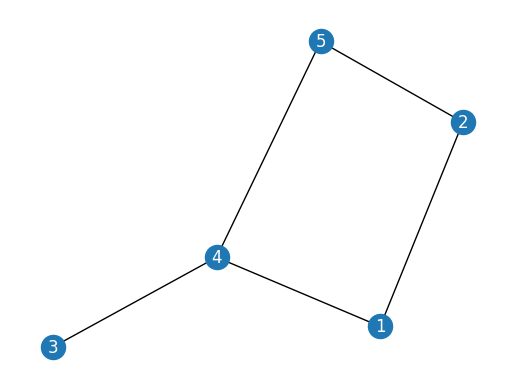

In [72]:
import matplotlib.pyplot as plt

nx.draw_networkx(G, font_color="white")
plt.axis('off');

<!-- Figure: Visualization of a toy network consisting of five nodes and five edges.\label{fig:getting-data:example-network} -->

Having a rudimentary understanding of networks, let us now define <span class="index">social network</span>s in the context of literary texts. In the networks we will extract from Shakespeare's plays, nodes are represented by speakers. What determines a connection (i.e., an edge) between two speakers is less straightforward and strongly dependent on the sort of relationship one wishes to capture. Here, we construct edges between two speakers if they are "in interaction with each other". Two speakers $A$ and $B$ interact, we claim, if an utterance of $A$ is preceded or followed by an utterance of $B$.

```{note}
Our approach here diverges from {cite:t}`moretti:2011`'s own approach in which he manually extracted these interactions, whereas we follow a fully automated approach. For Moretti, "two characters are linked if some words have passed between them: an interaction, is a speech act" {cite:p}`moretti:2011`.
```

Furthermore, in order to track the frequency of character interactions, each of the edges in our approach will hold a count representing the number of times two speakers have interacted. This number thus becomes a so-called attribute or property of the edge that has to be explicitly stored. The final result can then be described as a <span class="index">network</span> in which speakers are represented as nodes, and interactions between speakers are represented as weighted edges. Having defined the type of social network we aim to construct, the real challenge we face is to extract such networks from Shakespeare's plays in a data format that can be easily exchanged.

Fortunately, the Folger Digital Texts of Shakespeare provides annotations for
speaker turns, which give a rich information source that can be useful in the construction
of the character network. Now that we are able to parse XML, we can extract speaker turns
from the data files: the speaker turns and the entailing text uttered by a speaker are enclosed within `sp` tags. The ID of its corresponding speaker is stored in the `who` attribute. Consider the following fragment:

```xml
<sp xml:id="sp-0200" who="#Rosalind_AYL">
  <speaker xml:id="spk-0200">
    <w xml:id="w0035750">ROSALIND</w>
  </speaker>
  <ab xml:id="ab-0200">
    <w xml:id="w0035760" n="1.2.30">What</w>
    <c xml:id="c0035770" n="1.2.30"> </c>
    <w xml:id="w0035780" n="1.2.30">shall</w>
    <c xml:id="c0035790" n="1.2.30"> </c>
    <w xml:id="w0035800" n="1.2.30">be</w>
    <c xml:id="c0035810" n="1.2.30"> </c>
    <w xml:id="w0035820" n="1.2.30">our</w>
    <c xml:id="c0035830" n="1.2.30"> </c>
    <w xml:id="w0035840" n="1.2.30">sport</w>
    <pc xml:id="p0035850" n="1.2.30">,</pc>
    <c xml:id="c0035860" n="1.2.30"> </c>
    <w xml:id="w0035870" n="1.2.30">then</w>
    <pc xml:id="p0035880" n="1.2.30">?</pc>
  </ab>
</sp>
```

With this information about speaker turns, implementing a function to extract character interaction networks becomes trivial. Consider the function `character_network()` below, which takes as argument a `lxml.ElementTree` object and returns a character network represented as a <span class="index">`networkx.Graph`</span> object:

In [73]:
NSMAP = {'tei': 'http://www.tei-c.org/ns/1.0'}


def character_network(tree):
    """Construct a character interaction network.

    Construct a character interaction network for Shakespeare texts in
    the Folger Digital Texts collection. Character interaction networks
    are constructed on the basis of successive speaker turns in the texts,
    and edges between speakers are created when their utterances follow
    one another.

    Arguments:
        tree: An lxml.ElementTree instance representing one of the XML
            files in the Folger Shakespeare collection.

    Returns:
        A character interaction network represented as a weighted,
        undirected NetworkX Graph.

    """
    G = nx.Graph()
    # extract a list of speaker turns for each scene in a play
    for scene in tree.iterfind('.//tei:div2[@type="scene"]', NSMAP):
        speakers = scene.findall('.//tei:sp', NSMAP)
        # iterate over the sequence of speaker turns...
        for i in range(len(speakers) - 1):
            # ... and extract pairs of adjacent speakers
            try:
                speaker_i = speakers[i].attrib['who'].split('_')[0].replace('#', '')
                speaker_j = speakers[i + 1].attrib['who'].split('_')[0].replace('#', '')
                # if the interaction between two speakers has already
                # been attested, update their interaction count
                if G.has_edge(speaker_i, speaker_j):
                    G[speaker_i][speaker_j]['weight'] += 1
                # else add an edge between speaker i and j to the graph
                else:
                    G.add_edge(speaker_i, speaker_j, weight=1)
            except KeyError:
                continue
    return G

Note that this code employs search expressions in the <span class="index">XPath</span> syntax. The expression we pass to `tree.iterfind()`, for instance, uses a so-called predicate (`[@type="scene"]`) to select all `div2` elements that have a `"type"` attribute with a value of `"scene"`. In the returned part of the XML tree, we then only select the speaker elements (`sp`) and parse their `who` attribute, to help us reconstruct, or at least approximate, the conversations which are going on in this part of the play.

Let's test the function on one of Shakespeare's plays, <span class="index">*Hamlet*</span>:

In [74]:
tree = lxml.etree.parse('data/folger/xml/Ham.xml')
G = character_network(tree.getroot())

The extracted social network consists of 38 nodes (i.e. unique speakers) and 73 edges (i.e., unique <span class="index">speaker interactions</span>):

In [75]:
print(f"N nodes = {G.number_of_nodes()}, N edges = {G.number_of_edges()}")

N nodes = 38, N edges = 73


An attractive feature of network analysis is to visualize the extracted network. The visualization will be a graph in which speakers are represented by nodes and interactions between speakers by edges. To make our network graph more insightful, we will have the size of the nodes reflect the count of the interactions. We begin with extracting and computing the node sizes:

In [76]:
import collections

interactions = collections.Counter()

for speaker_i, speaker_j, data in G.edges(data=True):
    interaction_count = data['weight']
    interactions[speaker_i] += interaction_count
    interactions[speaker_j] += interaction_count

nodesizes = [interactions[speaker] * 5 for speaker in G]

In the code block above, we again make use of a <span class="index">`Counter`</span>,
which, as explained before, is a dictionary in which the values represent the counts of
the keys. Next, we employ NetworkX's plotting functionality to create the visualization of
the character network:

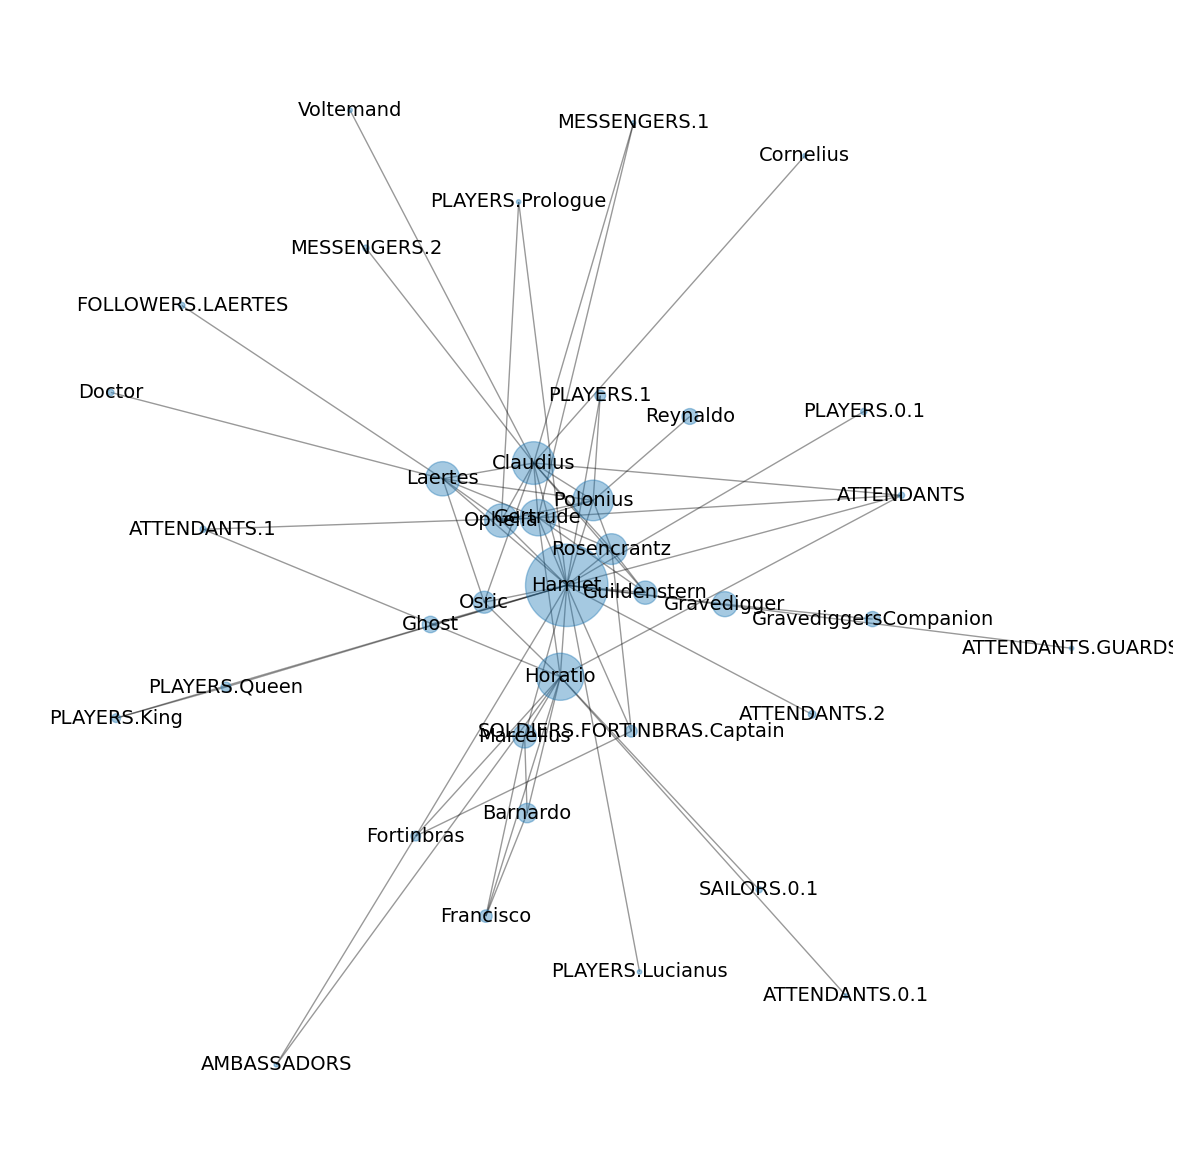

In [77]:
# Create an empty figure of size 15x15
fig = plt.figure(figsize=(15, 15))
# Compute the positions of the nodes using the spring layout algorithm
pos = nx.spring_layout(G, k=0.5, iterations=200)
# Then, add the edges to the visualization
nx.draw_networkx_edges(G, pos, alpha=0.4)
# Subsequently, add the weighted nodes to the visualization
nx.draw_networkx_nodes(G, pos, node_size=nodesizes, alpha=0.4)
# Finally, add the labels (i.e. the speaker IDs) to the visualization
nx.draw_networkx_labels(G, pos, font_size=14)
plt.axis('off');

<!-- Figure: Visualization of the character interaction network in *Hamlet*.\label{fig:getting-data:character-network} -->

As becomes clear in the resulting plot, <span class="index">NetworkX</span> is able to come up with an attractive visualization through the use of a so-called <span class="index">layout algorithm</span> (here, we fairly randomly opt for the `spring_layout`, but there exist many alternative layout strategies). The resulting plot understandably assigns Hamlet a central position in the plot, because of his obvious centrality in the social story-world evoked in the play. Less central characters are likewise pushed towards the boundaries of the graph. If we want to de-emphasize the frequency of interaction and focus instead on the fact of interaction, we can remove the edge weights altogether from our links, because these did not play an explicit role in Moretti's graph. Below we make a copy (`G0`) of the original graph and set all of its weights to 1, before replotting the network:

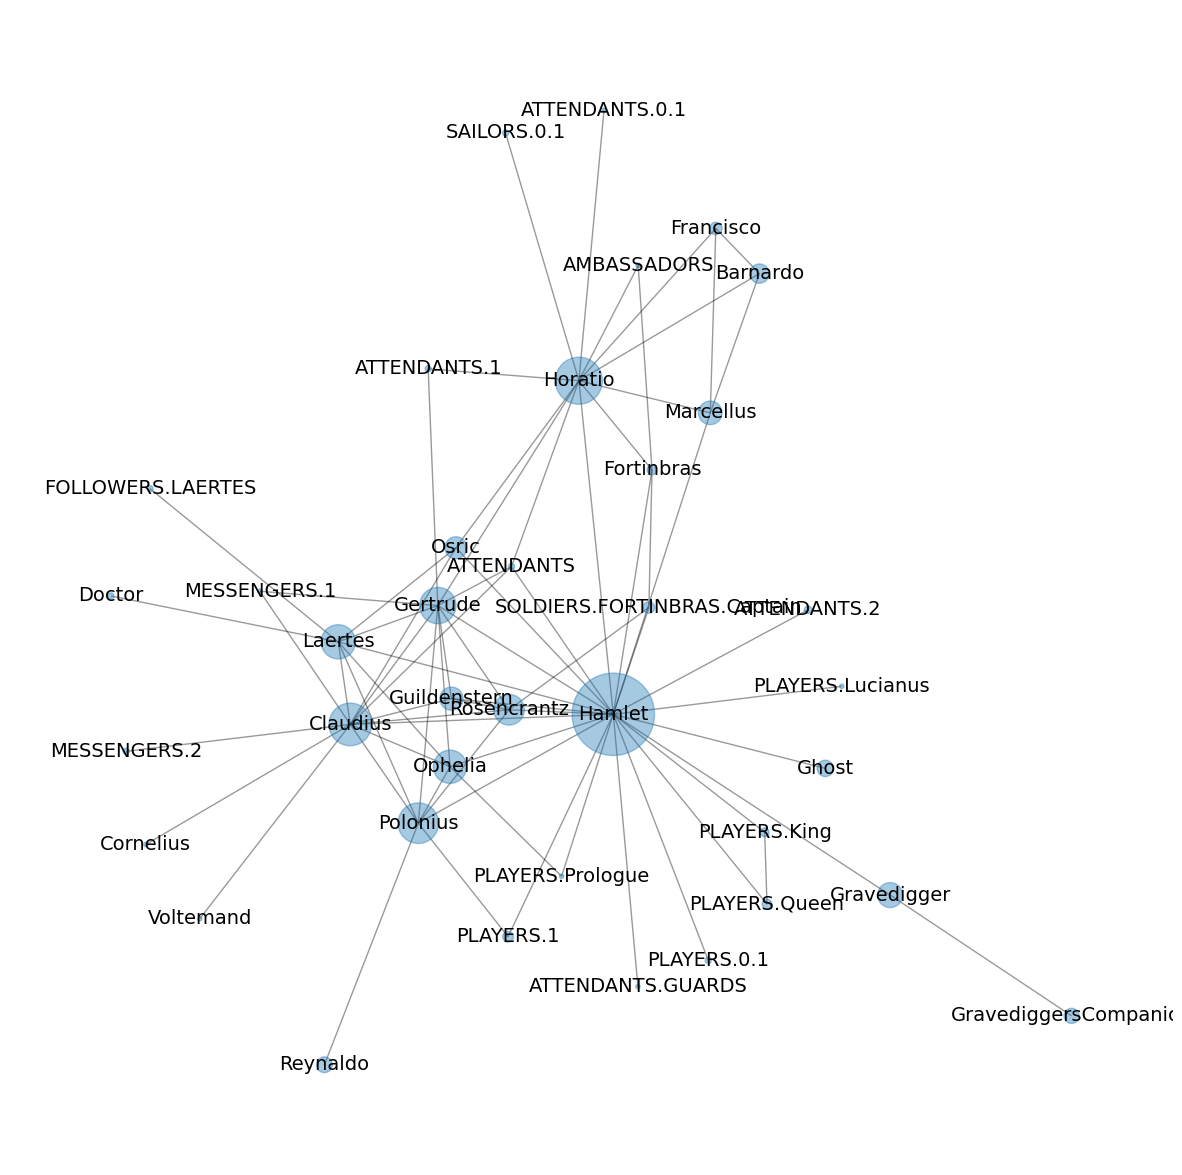

In [78]:
from copy import deepcopy
G0 = deepcopy(G)

for u, v, d in G0.edges(data=True):
    d['weight'] = 1

nodesizes = [interactions[speaker] * 5 for speaker in G0]

fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G0, k=0.5, iterations=200)
nx.draw_networkx_edges(G0, pos, alpha=0.4)
nx.draw_networkx_nodes(G0, pos, node_size=nodesizes, alpha=0.4)
nx.draw_networkx_labels(G0, pos, font_size=14)
plt.axis('off');

<!-- Figure: Visualization of the character interaction network in *Hamlet* without weights.\label{fig:getting-data:character-network-no-weights} -->

Note how for instance the two gravediggers are pushed much more to the periphery in this unweighted perspective on the data, reflecting the fact that the actual length of the conversation involving the gravediggers is no longer being considered. One experiment, suggested in {cite:t}`moretti:2011`, is relevant here and involves the manipulation of the graph. Moretti proposes the following challenging intervention:

> Take the protagonist again. For literary critics, [the visualization of the character network] is important because it’s a very meaningful part of the text; there is always a lot to be said about it; we would never think of discussing Hamlet – without Hamlet. But this is exactly what network theory tempts us to do: take the Hamlet-network ..., and remove Hamlet, to see what happens. {cite:p}`moretti:2011`

Removing Hamlet from the original text may be challenging, but removing him as a node from our network model is painless:

In [79]:
G0.remove_node('Hamlet')

We are now ready to plot the character network of *Hamlet*, without Hamlet:

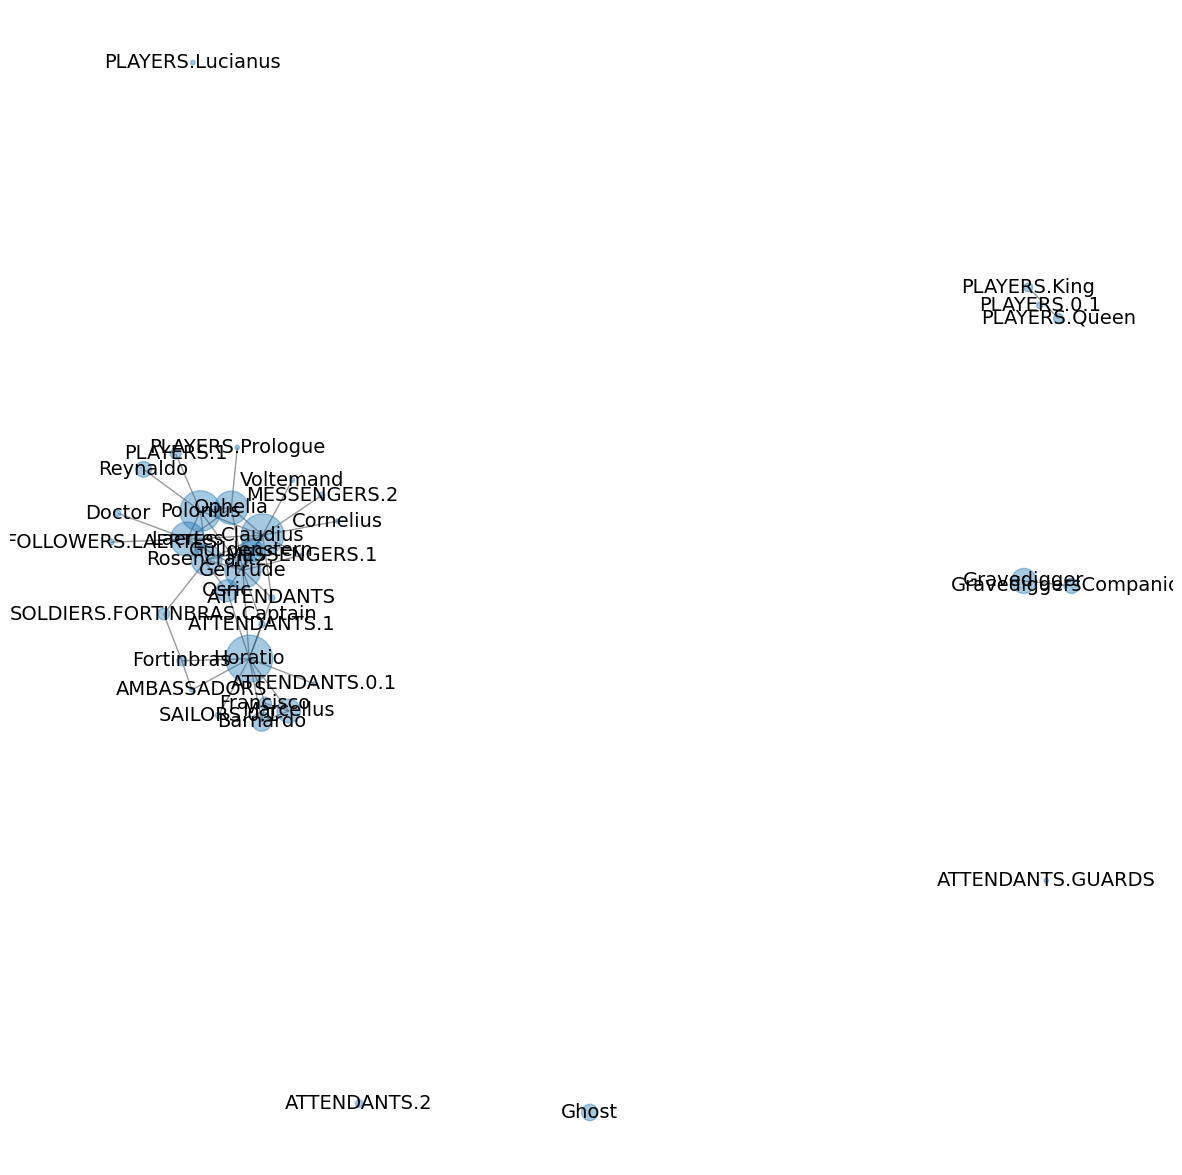

In [80]:
fig = plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G0, k=0.5, iterations=200)
nodesizes = [interactions[speaker] * 5 for speaker in G0]
nx.draw_networkx_edges(G0, pos, alpha=0.4)
nx.draw_networkx_nodes(G0, pos, node_size=nodesizes, alpha=0.4)
nx.draw_networkx_labels(G0, pos, font_size=14)
plt.axis('off');

<!-- Figure: Visualization of the character interaction network in *Hamlet* without the character Hamlet.\label{fig:getting-data:character-network-without-hamlet} -->

In his interpretation of the result, Moretti describes how the network tends to fall apart without Hamlet, separating the characters linked to the court from the others. We see indeed how (small communities of) outsiders, such as the gravedigger and his companion, become isolated in this much less dense network and, without their link to Hamlet, are banned to the periphery of the story-world.

```{margin}
For a complete overview of all export formats see the [NetworkX documentation](https://networkx.org/documentation/stable/reference/readwrite/index.html).
```
Should one want to move data out of <span class="index">NetworkX</span> for analysis in other software, NetworkX supports a variety of export formats (such as XML, CSV, GraphML, and JSON) which can be easily loaded into other software. For example, serializing the *Hamlet* network to a human-readable file in JSON format is easy, as is reconstructing our network graph after reloading the data in JSON format:

In [81]:
import json
from networkx.readwrite import json_graph

with open('hamlet.json', 'w') as f:
    json.dump(json_graph.node_link_data(G), f)

with open('hamlet.json') as f:
    d = json.load(f)

G = json_graph.node_link_graph(d)
print(f"Graph with {len(G.nodes())} nodes and {len(G.edges())} edges.")

Graph with 38 nodes and 73 edges.


## Conclusion and Further Reading

Much more can be said about network theory---or Shakespeare for that matter. This case study served to illustrate how various technologies for the structured manipulation of data have an important role to play in data science for the humanities. In what preceded, we have explored a number of common data formats to exchange digital data, and how Python can be used to read, parse, manipulate, and write these formats. Many other data formats exist than the ones discussed in this chapter, such as epub, doc(x), or postscript, to name but a few. Converting between document formats is a chore and often tools other than Python are useful for operations on a large number of files. [<span class="index">Pandoc</span>](https://pandoc.org), which bills itself as a universal document converter, is adept at extracting text from Office Open XML (.docx) and OpenDocument (.odt) files.

Which data formats one should choose in a particular project will always depend on the ad hoc requirements of that specific project. XML is often used in the humanities because it is relatively reader-friendly and easy to manipulate, which is an important advantage for instance in the sphere of scholarly editing, where human editors intensively have to interact with their digital data. For textual datasets, the tree-like model which XML offers is therefore typically an intuitively attractive approach. Nevertheless, XML can also be considered a fairly verbose format: for simpler or less text-oriented datasets, the application of XML can therefore feel like "overkill" in comparison to simpler tabular models, such as CSV, that often take a user a long way already.

Because of its verbosity, XML takes relatively longer to process, which explains why it is less frequently encountered for exchanging data in the context of the web. In this domain, the simpler, yet highly flexible JSON format is often preferred by developers. Note that all XML structures can also be expressed through combining hierarchies of objects and lists in JSON, but that JSON is perhaps less intuitive to manually manipulate by (textual) scholars, especially when these nested structure become deeper and more complex. JSON is also relevant because this is the data format that is often returned by so-called <span class="index">API</span>s or "application programming interfaces". These are services that live on the web and which can be queried using URLs. However, instead of returning HTML-encoded pages (that are meant to be visualized in browsers), these APIs return "pure data", encoded for instance as JSON objects, that are meant for further downstream processing in all sorts of third-party applications. Currently, APIs are still notoriously unstable, in the sense that their interface or "query endpoints" frequently change over time (which is why we did not cover them in this chapter), but once you are aready to query some of the beautiful services that are emerging in the humanities---the [API offered by the Rijksmuseum](https://www.rijksmuseum.nl/en/api) in Amsterdam is a particularly rich example---you will be happy that you know a thing or two already about parsing JSON.

All in all, one is free to adopt any particular data modeling strategy and much will depend on the task at hand and the trade-off between, for instance, verbosity and ease of manipulation. No matter what choice is eventually made, the reader should always remember that *a dataset is only as good as its documentation*. If you want your data to be useful to others (or even to your future self), it is good practice to include a <span class="index">README</span> file with your data that concisely states the origin of the data and the manipulations you performed on it. Apart from describing the license under which you publish the data, a README is also a good place to justify some of the design choices you make when (re)modeling the data, as these are typically easily forgotten and hard to reconstruct at a later stage. Documenting such interventions might seem unnecessary at the time of coding but they contribute tremendously to the sustainability of the scholarly data we produce. For that same reason, scholars should always try to stay away from proprietary data formats that depend on specific, sometimes commercial, software products to be read: these data formats will only live as long as the software that supports it. Moreover, in the case of expensive software products, the use of closed data formats prevents a significant portion of less well-off scholars from benefiting from your data. Additionally, preferring human-readable data formats to binary data, whenever possible, is also likely to increase the lifespan of your data.